<a href="https://colab.research.google.com/github/MuratCKoc/salesinsider/blob/main/ProphetsPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
# First setup the dependencies

#Our most important library is FB Prophet which will be using rule based learning
from fbprophet import Prophet
import pandas as pd
import numpy as np
import matplotlib

In [61]:
# We then read the CSV file from GitHub
df = pd.read_csv('https://raw.githubusercontent.com/MuratCKoc/salesinsider/main/salesinsider/data/Groceries_dataset.csv')
# As the file has multiple columns, we select the columns that we will be using for the project.
data_df = df[['Date', 'itemDescription']]
data_df.head()

,Date,itemDescription
0,21-07-2015,tropical fruit
1,05-01-2015,whole milk
2,19-09-2015,pip fruit
3,12-12-2015,other vegetables
4,01-02-2015,whole milk


In [62]:
# We then use the get dummies function to convert each of the food items into an indicator.
# What this means is that all the data is converted into a single number (1).
cat_df = pd.get_dummies(data_df["itemDescription"])
# We then concatenate the data
final_df = pd.concat([data_df,cat_df],axis=1)
# After concatenation of the data we then group all the data by the dates which gives a table we can use to conduct our machine learning algorithm.
grouped_df = final_df.groupby("Date", as_index=False).sum()
grouped_df.head()

,Date,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,01-01-2014,2,0,0,0,0,0,0,0,0,...,0,0,2,2,0,0,0,2,4,0
1,01-01-2015,0,0,0,0,0,0,0,0,1,...,1,0,0,1,0,1,0,3,0,0
2,01-02-2014,0,0,0,0,0,0,0,0,2,...,0,0,2,1,0,1,0,1,3,0
3,01-02-2015,0,1,0,1,0,0,0,0,2,...,0,0,1,0,0,1,0,9,6,0
4,01-03-2014,0,0,0,0,0,0,0,0,0,...,0,0,1,3,0,1,0,1,1,0


/Users/mkc/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/mkc/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
          Date  zw

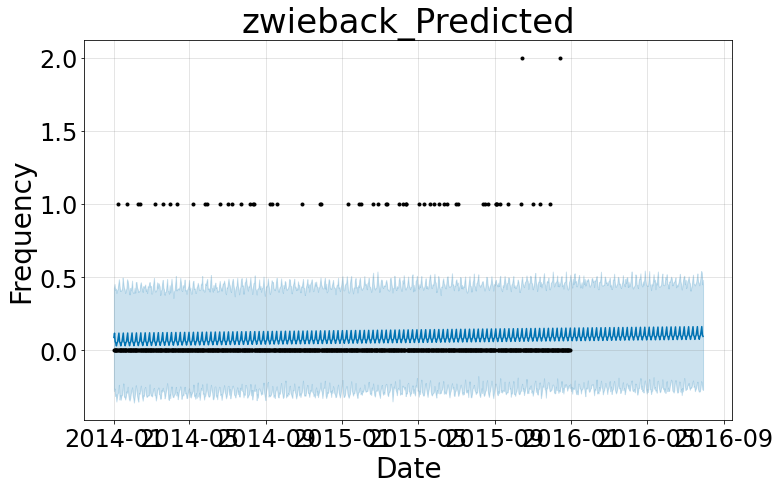

In [77]:
# Create master dataframe
master_df = pd.DataFrame()

for j in range(727, len(grouped_df.index)):
   # Predict thru all transactions.
  for i in range (167, len(grouped_df.columns)): 
    prophet_df = grouped_df[["Date", grouped_df.columns[i]]]
    prophet_df.columns = ["ds", 'y']
    prophet_df['ds'] = pd.to_datetime(prophet_df.ds,format='%d-%m-%Y') 
    model = Prophet()
    model.fit(prophet_df)
    future = model.make_future_dataframe(periods=213)
    forecast = model.predict(future)
    predicted_df = forecast[["ds", "yhat"]]
    predicted_df.yhat = predicted_df.yhat.round()

    predicted_ColName = grouped_df.columns[i]+"_Predicted"

    fig = model.plot(forecast, xlabel='Date', ylabel='Frequency')
    ax = fig.gca()
    ax.set_title(predicted_ColName, size=34)
    ax.set_xlabel("Date", size=28)
    ax.set_ylabel("Frequency", size=28)
    ax.tick_params(axis="x", labelsize=15)
    ax.tick_params(axis="y", labelsize=15)
    fig
    fig.savefig("static/images/plots/"+predicted_ColName+".png")

    predicted_df = predicted_df.rename( columns={"ds": "Date", "yhat": predicted_ColName})

    print(predicted_df)
    #initialize container df
    if len(master_df.index) == 0:
      master_df = predicted_df.copy()
    else:
      master_df[predicted_ColName] = predicted_df[predicted_ColName]
    colName = grouped_df.columns[i]
    master_df[colName] = grouped_df[colName]

    if i == len(grouped_df.columns):
      break
    print (master_df)

In [64]:
# This table shows us a consolidated view of the table with the output of machine learning applied here.
# Notice that we have double the number of columns.
master_df.head()

,Date,whole milk_Predicted,whole milk,yogurt_Predicted,yogurt,zwieback_Predicted,zwieback
0,2014-01-01,3.0,2.0,2.0,4.0,0.0,0.0
1,2014-01-02,2.0,3.0,2.0,0.0,0.0,0.0
2,2014-01-03,2.0,1.0,2.0,3.0,0.0,0.0
3,2014-01-04,3.0,9.0,2.0,6.0,0.0,0.0
4,2014-01-05,3.0,1.0,2.0,1.0,0.0,0.0


In [65]:
fig1.savefig("static/images/plots/ASD.png")

In [66]:
# We then have to start cleaning up the table and remove all "NAN"s from the predicted columns. This will make it easier for visualization purposes.
clean_df = master_df
clean_df = clean_df.replace(np.nan,"")
clean_df

,Date,whole milk_Predicted,whole milk,yogurt_Predicted,yogurt,zwieback_Predicted,zwieback
0,2014-01-01,3.0,2,2.0,4,0.0,0
1,2014-01-02,2.0,3,2.0,0,0.0,0
2,2014-01-03,2.0,1,2.0,3,0.0,0
3,2014-01-04,3.0,9,2.0,6,0.0,0
4,2014-01-05,3.0,1,2.0,1,0.0,0
...,...,...,...,...,...,...,...
936,2016-07-26,5.0,,2.0,,0.0,
937,2016-07-27,5.0,,2.0,,0.0,
938,2016-07-28,5.0,,2.0,,0.0,
939,2016-07-29,5.0,,2.0,,0.0,


In [67]:
# When tried to move the tables into SQL we received errors, the cause of this was the certain column names have parenthesis.
# The parentheses are escape strings which cause an error, so we have to replace them.
clean_df.rename(columns={'flower (seeds)' : 'flower seeds'}, inplace=True)
clean_df.rename(columns={'liquor (appetizer)':'liquor appetizer'}, inplace=True)
clean_df.rename(columns={'flower (seeds)_Predicted' : 'flower seeds_Predicted'}, inplace=True)
clean_df.rename(columns={'liquor (appetizer)_Predicted':'liquor appetizer_Predicted'}, inplace=True)

In [68]:
# This is to check if the strings have been changed.
list(clean_df)

['Date',
 'whole milk_Predicted',
 'whole milk',
 'yogurt_Predicted',
 'yogurt',
 'zwieback_Predicted',
 'zwieback']

In [69]:
# We then proceed to move the table to SQL
# Import SQLAlchemy Dependencies 
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
from config import database_url

In [70]:
# To update database with dataframe
def Update_Database(df_name, table_name):
    engine = create_engine(database_url, echo=False)
    session = Session(engine)
    Base = automap_base()
    Base.prepare(engine, reflect=True)    
    cxn = engine.connect()
    df_name.to_sql(name=table_name, con=engine, if_exists='append', index=True)
    print(table_name + ' added')
    #Add primary key
    with engine.connect() as con:
        con.execute('ALTER TABLE `predicted_table` ADD PRIMARY KEY (`Date`);')

In [71]:
Update_Database(clean_df, "predicted_table")

predicted_table added


ProgrammingError: (psycopg2.errors.SyntaxError) syntax error at or near "`"
LINE 1: ALTER TABLE `predicted_table` ADD PRIMARY KEY (`Date`);
                    ^

[SQL: ALTER TABLE `predicted_table` ADD PRIMARY KEY (`Date`);]
(Background on this error at: http://sqlalche.me/e/13/f405)